#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta, date
from calendar import monthrange
from pytz import timezone
import pandas as pd
import numpy as np
import feather
import datetime
import pytz
import csv
import os
import matplotlib.pyplot as plt

%matplotlib inline

def get_dates_in_month(year, month, time_zone):
    num_days = monthrange(year, month)[1]
    first_date_of_month = datetime.datetime(year,month,1, tzinfo=time_zone)
    last_date_of_month =  datetime.datetime(year,month,num_days, tzinfo=time_zone)
    return get_dates_inrange(first_date_of_month, last_date_of_month)


def get_dates_inrange(date1, date2):
    if (not isinstance(date1, datetime.datetime)) | (not isinstance(date2, datetime.datetime)):
        return "date1 and date2 should be of type datetime.date"
    num_days = (date2 - date1).days + 1
    date_list = [date1 + datetime.timedelta(days=x) for x in range(0, num_days)]
    return date_list

#### Read data

In [103]:
DATA_FOLDER = './'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
date_df = pd.read_pickle("russian_holidays.pkl")
geography = pd.read_csv('geography.csv')
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
holiday_filepath = 'hol.feather'
holidays = feather.read_dataframe(holiday_filepath)

(2935849, 6)
(214200, 3)


Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100


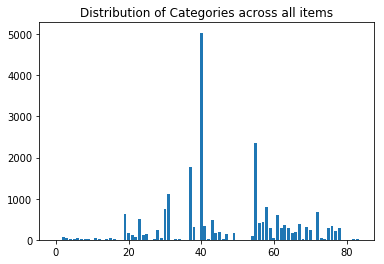

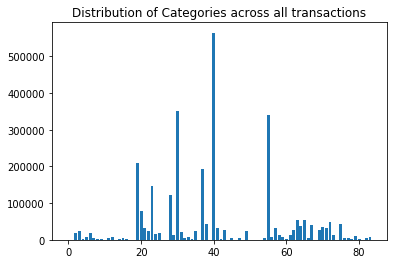

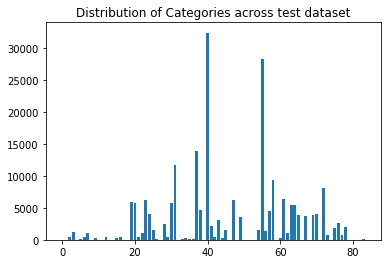




# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0




In [104]:
print(sales.shape)
print(test.shape)
print("\n")
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(sales.shop_id.nunique()))
print("  # unique items: {}".format(sales.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))


%matplotlib inline
transactions = sales
# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='left')

unique_categories, count = np.unique(items.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories, count)    
plt.title( "Distribution of Categories across all items")
plt.show()

unique_categories_trans, count_trans = np.unique(transactions.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_trans, count_trans)
plt.title("Distribution of Categories across all transactions")
plt.show()

test_mod = pd.merge(test, items[['item_id', 'item_category_id']], on='item_id', how='left')
unique_categories_test, count_test = np.unique(test_mod.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_test, count_test)
plt.title("Distribution of Categories across test dataset")
plt.show()

print("\n\n")

items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

print("\n")

##### Building the shops data frame

In [105]:
# Setting the shop_type
shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'МТРЦ', 'ТК']
shops["shop_type"] = shops.shop_name.apply(lambda x: x.split()[1] if x.split()[1] in shop_types else 'OTH')

# Setting the city for each shop
shops["city"] = shops.shop_name.apply(lambda x: x.split()[0].replace("!", ""))

# Appending the geographic info to shops df
shops = pd.merge(shops, geography.drop(['city_eng'], axis=1), on='city', how='inner')

print(shops.shape)
shops.head()

(60, 8)


,shop_name,shop_id,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,"!Якутск Орджоникидзе, 56 фран",0,OTH,Якутск,9,Sakha Republic,Far East,8395
1,"!Якутск ТЦ ""Центральный"" фран",1,ТЦ,Якутск,9,Sakha Republic,Far East,8395
2,"Якутск Орджоникидзе, 56",57,OTH,Якутск,9,Sakha Republic,Far East,8395
3,"Якутск ТЦ ""Центральный""",58,ТЦ,Якутск,9,Sakha Republic,Far East,8395
4,"Адыгея ТЦ ""Мега""",2,ТЦ,Адыгея,3,Adygea Republic,South,1589


#### Building a date df, and block_num_info df for adding temporal data.

In [106]:
# setting up the calendar and the Block_num info dataframe

moscow = timezone('Europe/Moscow')
train_first_date = datetime.datetime(2013,1,1, tzinfo=moscow)
train_last_date =  datetime.datetime(2015,11,30, tzinfo=moscow)

date_df = pd.DataFrame(get_dates_inrange(train_first_date, train_last_date), columns=['date'])

date_df['weekday'] = date_df['date'].apply(lambda x: x.isoweekday())
date_df['is_weekend'] = date_df['weekday'] > 5

# Holidays dataframe - (preparing df)
holidays_b = holidays
holidays_b['date_str'] = holidays_b.date.apply(lambda x: x.isoformat().split("T")[0])
holidays_b['off_day'] =  holidays_b.h_type.apply(lambda x: x.split(",")[0] == 'National holiday')
holidays_b['is_holiday'] = True

date_df['date_str'] = date_df.date.apply(lambda x: x.isoformat().split("T")[0])

date_df = pd.merge(date_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
date_df['is_holiday'].fillna(False, inplace=True)

date_df = pd.merge(date_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
date_df.loc[date_df.loc[:, 'weekday'] > 5, 'off_day'] = True


def add_date_block_num(d):
    if(d.year == 2013):
        base=0
    elif(d.year == 2014):
        base=12
    elif(d.year == 2015): 
        base=24
    return base + (d.month-1)

date_df['date_block_num'] = date_df['date'].apply(lambda x: add_date_block_num(x))

date_df.head()

# Block info df

block_num_info = date_df[date_df.is_weekend == True].groupby('date_block_num')['is_weekend'].sum().reset_index(name = "weekends")

block_num_info['holidays'] = date_df[date_df.is_holiday == True].groupby('date_block_num')['is_holiday'].sum()
block_num_info['holidays'].fillna(0, inplace=True)

block_num_info['off_days'] = date_df[date_df.off_day == True].groupby('date_block_num')['off_day'].sum()
block_num_info['off_days'].fillna(0, inplace=True)

block_num_info.head()

,date_block_num,weekends,holidays,off_days
0,0,8.0,7.0,14
1,1,8.0,2.0,8
2,2,10.0,2.0,11
3,3,8.0,0.0,8
4,4,8.0,9.0,16


#### Build the initial training df

In [107]:
# 'sales' is the input training dataframe
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [108]:
# remove date column
sales_monthly = sales.drop(['date'], axis=1)

# Aggregating item_cnt_day (summing) and item_price(averaging)
agg_funcs = {'item_cnt_day':np.sum, 'item_price':np.mean}
sales_monthly = sales_monthly.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_funcs).reset_index()

# rename the columns
sales_monthly.rename(columns={'item_price':'item_avg_price', 'item_cnt_day':'item_cnt_month'}, inplace=True)

# Adding seasonality - month numbers (jan1, feb-2, march-3....dec-12)
sales_monthly['month'] = (sales_monthly['date_block_num'] % 12)+1

# Appending shop information
sales_monthly = pd.merge(sales_monthly, shops, on='shop_id', how='left')

# Appending block_num_info (temporal features)
sales_monthly = pd.merge(sales_monthly, block_num_info, on='date_block_num', how='left')

print(sales_monthly.shape)
sales_monthly.head()


(1609124, 16)


,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow,weekends,holidays,off_days
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395,8.0,7.0,14
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395,8.0,7.0,14
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395,8.0,7.0,14
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395,8.0,7.0,14
4,0,0,51,2.0,128.5,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395,8.0,7.0,14


In [ ]:
# Bag of Words DTM (Document Term Matrix)
vect_bow = CountVectorizer()
vect_bow.fit(list_of_item_names)
dtm_bow = vect_bow.transform(list_of_item_names)
pd.DataFrame(dtm_bow.toarray(), columns=vect_bow.get_feature_names())

In [ ]:
# Tf-Idf DTM

vect_tfidf = TfidfVectorizer(max_features = 500)
vect_tfidf.fit(list_of_item_names)
dtm_tfidf = vect_tfidf.transform(list_of_item_names)
pd.DataFrame(dtm_tfidf.toarray(), columns=vect_tfidf.get_feature_names())

#### To Do:

For training:

1. Handle categorical features
2. replace Item id by item tf-idf dtm features
3. get rid of temporal features month, block_num
4. get rid of shop name

For test dataset:

1. calculate avg. price for the items in test data set
2. Append shop features
3. Append item tf-idf dtm features

In [114]:
# Linear Regression


numeric_features = list(["item_avg_price","time_wrt_utc", "dist_from_moscow", "weekends", "holidays", "off_days"])
train = sales_monthly[numeric_features]
target = sales_montly['item_cnt_month']
train.head()

,item_avg_price,time_wrt_utc,dist_from_moscow,weekends,holidays,off_days
0,221.0,9,8395,8.0,7.0,14
1,347.0,9,8395,8.0,7.0,14
2,247.0,9,8395,8.0,7.0,14
3,221.0,9,8395,8.0,7.0,14
4,128.5,9,8395,8.0,7.0,14


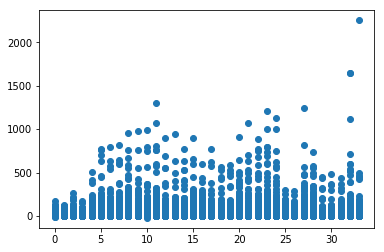

In [123]:
agg_funcs = {'item_cnt_day':np.sum, 'item_price':np.mean}
sales_monthly.groupby([ 'date_block_num', 'item_id', ]).agg(agg_funcs).reset_index()